## Nested Logit

In [1]:
import pandas as pd
import pymc as pm
import patsy
import numpy as np
import pytensor.tensor as pt
import arviz as az
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../..')

%reload_ext autoreload
from pymc_marketing.customer_choice.nested_logit import NestedLogit

In [2]:
df = pd.read_csv('../../../../data/choice_wide_heating.csv')
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


In [17]:
utility_formulas = ['gc ~ ic_gc + oc_gc | income ', 
                    'ec ~ ic_ec + oc_ec | income ',
                    'gr ~ ic_gr + oc_gr | income ', 
                    'er ~ ic_er + oc_er | income ', 
                    'hp ~ ic_hp + oc_hp | income ']

nesting_structure = {'central': ['gc', 'ec'], 
                     'room': {'hp': ['hp'], 'r': ['gr', 'er']}}

#nesting_structure = {'central': ['gc', 'ec'], 
#                     'room': ['hp', 'gr', 'er']}


nstL = NestedLogit(df, utility_formulas, 'depvar', covariates=['ic', 'oc'], nesting_structure=nesting_structure)
nstL

In [18]:
X, F, y = nstL.preprocess_model_data(df, utility_formulas)
print(X.shape)
F.shape

(900, 5, 2)


In [19]:
nstL.coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': ['income'],
 'nests': ['central', 'room', 'room_hp', 'room_r'],
 'obs': range(0, 900)}

In [20]:
nest_indices = nstL.nest_indices
nest_indices

{'top': {'central': array([0, 1]), 'room': array([2, 3, 4])},
 'mid': {'room_hp': [4], 'room_r': [2, 3]}}

In [22]:
lambda_lkup = nstL.lambda_lkup
lambda_lkup

{'central': 0, 'room': 1, 'room_hp': 2, 'room_r': 3}

In [23]:
coords = nstL.coords
coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': ['income'],
 'nests': ['central', 'room', 'room_hp', 'room_r'],
 'obs': range(0, 900)}

In [43]:
N = df.shape[0]

def make_exp_nest(U, w_nest, lambdas_nests, nest, level='top'):
    if '_' in nest:
        parent, child = nest.split('_')
    else: 
        parent = None
    y_nest = U[:, nest_indices[level][nest]]
    if len(nest_indices[level][nest]) > 1:
        max_y_nest = pm.math.max(y_nest, axis=0)
        P_y_given_nest = pm.Deterministic(
            f"p_y_given_{nest}",
            pm.math.softmax(y_nest / lambdas_nests[lambda_lkup[nest]], axis=1),
        )
    else:
        max_y_nest = pm.math.max(y_nest)
        ones = pm.math.ones((N, 1))
        P_y_given_nest = pm.Deterministic(f"p_y_given_{nest}", ones)
    if parent is None:
        lambda_ = lambdas_nests[lambda_lkup[nest]]
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambda_)
        )
        W_nest = w_nest + I_nest * lambda_
    else:
        l1 = lambdas_nests[lambda_lkup[nest]]
        l2 = lambdas_nests[lambda_lkup[parent]]
        lambdas_ = l1 * l2
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambdas_)
        )
        W_nest = w_nest + I_nest * (lambdas_)

    exp_W_nest = pm.math.exp(W_nest)
    return exp_W_nest, P_y_given_nest


def make_P_nest(U, W, w_nest, lambdas_nests, level):
    conditional_probs = {}
    for n in nest_indices[level].keys():
        exp_W_nest, P_y_given_nest = make_exp_nest(U, w_nest, 
            lambdas_nests, n, level)
        if W is None:
            conditional_probs[n] = {'exp': exp_W_nest, 'P_y_given': P_y_given_nest}
        else: 
            exp_W_nest = pm.math.sum(exp_W_nest, axis=1)
            conditional_probs[n] = {'exp': exp_W_nest, 'P_y_given': P_y_given_nest}

    
    denom = pm.Deterministic(f'denom_{level}', pm.math.sum([conditional_probs[n]['exp'] for n in nest_indices[level].keys()], axis=0))
    nest_probs = {}
    for n in nest_indices[level].keys():
        P_nest = pm.Deterministic(f'P_{n}', (conditional_probs[n]['exp'] / denom))
        nest_probs[n] = P_nest
    return conditional_probs, nest_probs
    

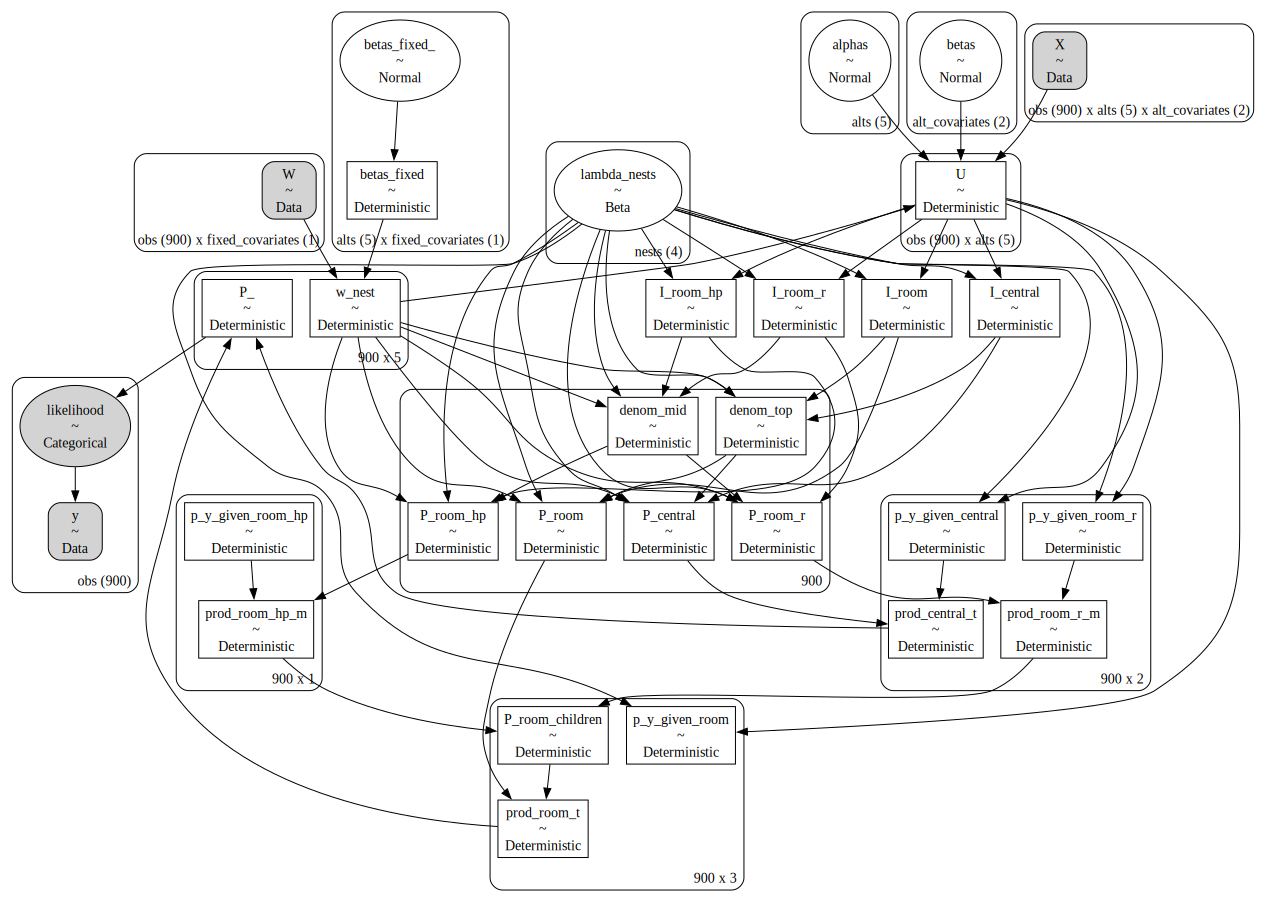

In [81]:
def make_model(X, y, W, N=900):
    with pm.Model(coords=coords) as model:
        alphas = pm.Normal('alphas', 0, 1, dims='alts')
        betas = pm.Normal('betas', 0, 1, dims=('alt_covariates'))
        lambdas_nests = pm.Beta('lambda_nests', 2, 2, dims='nests')
        
        if W is None:
            w_nest = pm.math.zeros((len(coords['obs']), 
                                    len(coords['alts'])))
        else: 
            W_data = pm.Data('W', W, dims=('obs', 'fixed_covariates'))
            betas_fixed_ = pm.Normal('betas_fixed_', 0, 1, dims=('alts', 'fixed_covariates'))
            betas_fixed = pm.Deterministic('betas_fixed', pt.set_subtensor(betas_fixed_[-1, :], 0), 
                dims=('alts','fixed_covariates'))
            w_nest = pm.Deterministic('w_nest', pm.math.dot(W_data, betas_fixed.T))
        X_data = pm.Data('X', X,  dims=('obs', 'alts', 'alt_covariates'))
        y_data = pm.Data('y', y, dims='obs')

        # Compute utility as a dot product
        alphas = pt.set_subtensor(alphas[-1], 0)
        u = alphas + pm.math.dot(X_data, betas)
        U = pm.Deterministic('U', w_nest + u, dims=('obs', 'alts'))
        
        ## Top Level
        cond_prob_t, nest_prob_t = make_P_nest(U, W, w_nest, lambdas_nests, 'top')
        ## Mid Level
        if 'mid' in nest_indices.keys():
            cond_prob_m, nest_prob_m = make_P_nest(U, W, w_nest, lambdas_nests, 'mid')
        else: 
            cond_prob_m, nest_prob_m = 1, 1
        
        ## Construct Paths Bottom -> Up
        
        child_nests = {}
        path_prods_m = {}
        ordered = [(key, min(vals)) for key, vals in nest_indices['mid'].items()]
        middle_nests = [x[0] for x in sorted(ordered, key=lambda x: x[1])]
        for idx, n in enumerate(middle_nests):
            is_last = idx == len(middle_nests) - 1
            parent, child = n.split('_')
            P_nest = nest_prob_m[n]
            P_y_given_nest = cond_prob_m[n]['P_y_given']
            prod = pm.Deterministic(f'prod_{n}_m', (P_nest[:, pt.newaxis]*P_y_given_nest))
            if parent in path_prods_m:
                path_prods_m[parent].append(prod)
            else:
                path_prods_m[parent] = [prod]
            if is_last:
                P_ = pm.Deterministic(f'P_{parent}_children',  pm.math.concatenate(path_prods_m[parent], axis=1))
                child_nests[parent] = P_

        path_prods_t = []
        ordered = [(key, min(vals)) for key, vals in nest_indices['top'].items()]
        top_nests = [x[0] for x in sorted(ordered, key=lambda x: x[1])]
        for idx, n in enumerate(top_nests):
            P_nest = nest_prob_t[n]
            if n in child_nests:
                P_y_given_nest = child_nests[n]
            else:
                P_y_given_nest = cond_prob_t[n]['P_y_given']
            prod = pm.Deterministic(f'prod_{n}_t', (P_nest[:, pt.newaxis]*P_y_given_nest))
            path_prods_t.append(prod)
        P_ = pm.Deterministic('P_', pm.math.concatenate(path_prods_t, axis=1))
        
        choice_obs = pm.Categorical("likelihood", p=P_, observed=y_data, dims="obs")

    return model


model = make_model(X, y, W=F)
pm.model_to_graphviz(model)

In [ ]:
nest_indices['mid']

data = {'room_hp': [4], 'room_r': [2, 3]}


['room_r', 'room_hp']

In [83]:
with model: 
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(
        target_accept=.97,
        nuts_sampler='numpyro',
        idata_kwargs={"log_likelihood": True}, 
        random_seed=101))
    

Sampling: [alphas, betas, betas_fixed_, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [84]:
az.summary(idata, var_names=['betas', 'alphas', 'betas_fixed'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.003,0.001,-0.004,-0.001,0.000,0.000,3764.0,3567.0,1.0
betas[oc],-0.006,0.001,-0.009,-0.004,0.000,0.000,5409.0,3184.0,1.0
alphas[gc],-0.090,0.749,-1.432,1.361,0.013,0.011,3114.0,3090.0,1.0
alphas[ec],0.136,0.741,-1.172,1.552,0.013,0.012,3066.0,2893.0,1.0
alphas[gr],-0.673,0.752,-2.051,0.753,0.013,0.011,3318.0,3001.0,1.0
alphas[er],0.630,0.740,-0.730,2.038,0.013,0.011,3187.0,2780.0,1.0
alphas[hp],-0.000,0.981,-1.855,1.786,0.014,0.017,5263.0,2782.0,1.0
"betas_fixed[gc, income]",0.007,0.716,-1.408,1.325,0.020,0.011,1323.0,2187.0,1.0
"betas_fixed[ec, income]",0.014,0.716,-1.352,1.373,0.020,0.011,1320.0,2152.0,1.0
"betas_fixed[gr, income]",0.018,0.669,-1.267,1.310,0.018,0.011,1311.0,2225.0,1.0


<Axes: >

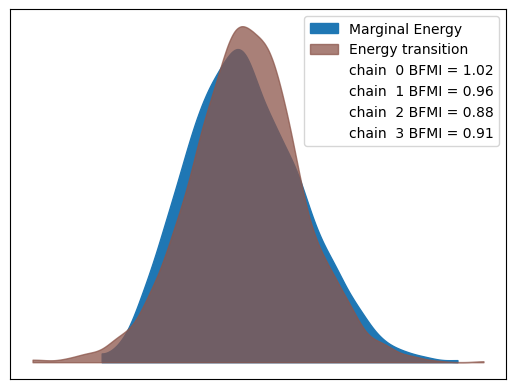

In [85]:
az.plot_energy(idata)

In [48]:
pd.DataFrame(idata['prior']['p_y_given_room'].mean(dim=('chain', 'draw')).values)

,0,1,2
0,0.321096,0.445671,0.233233
1,0.337649,0.440366,0.221985
2,0.332668,0.374084,0.293248
3,0.312001,0.387154,0.300846
4,0.434085,0.508906,0.057009
...,...,...,...
895,0.337687,0.500910,0.161403
896,0.346016,0.479956,0.174027
897,0.435022,0.536000,0.028977
898,0.354715,0.422194,0.223091


In [49]:
pd.DataFrame(idata['prior']['p_y_given_central'].mean(dim=('chain', 'draw')).values)

,0,1
0,0.459834,0.540166
1,0.462014,0.537986
2,0.478609,0.521391
3,0.457447,0.542553
4,0.480910,0.519090
...,...,...
895,0.457898,0.542102
896,0.451274,0.548726
897,0.461977,0.538023
898,0.451337,0.548663


In [50]:
w_nest = pd.DataFrame(idata['prior']['w_nest'].mean(dim=('chain', 'draw')).values)
w_nest 

a = np.exp(w_nest + (idata['prior']['I_room'][0, 0]*idata['prior']['lambda_nests'][0, 0, 0]).item())

b = np.exp(w_nest + (idata['prior']['I_room'][0, 0]*idata['prior']['lambda_nests'][0, 0, 0]).item())

np.sum([np.sum(a, axis=1) , np.sum(a, axis=1)], axis=0)
a



,0,1,2,3,4
0,1.166477,1.229278,0.867967,0.859866,1.053405
1,1.132986,1.176228,0.917338,0.911214,1.053405
2,1.116602,1.150568,0.943067,0.938027,1.053405
3,1.084543,1.100915,0.996710,0.994043,1.053405
4,1.084543,1.100915,0.996710,0.994043,1.053405
...,...,...,...,...,...
895,1.149609,1.202460,0.892311,0.885168,1.053405
896,1.166477,1.229278,0.867967,0.859866,1.053405
897,1.132986,1.176228,0.917338,0.911214,1.053405
898,1.132986,1.176228,0.917338,0.911214,1.053405


In [52]:
pd.DataFrame(idata['prior']['denom_top'].mean(dim=('chain', 'draw')).values).round(2)

,0
0,3.013180e+10
1,7.735343e+06
2,1.290017e+05
3,1.161300e+02
4,1.161300e+02
...,...
895,4.807196e+08
896,3.013180e+10
897,7.735343e+06
898,7.735343e+06


In [54]:
pd.DataFrame(idata['prior']['P_room'].mean(dim=('chain', 'draw')).values)

,0
0,0.547478
1,0.547478
2,0.547478
3,0.547478
4,0.547478
...,...
895,0.547478
896,0.547478
897,0.547478
898,0.547478


In [ ]:
pd.DataFrame(idata['prior']['P_'].mean(dim=('chain', 'draw')).values).sum(axis=1)

In [ ]:
model.debug()

In [57]:
idata['prior']['P_central'].mean(dim=('chain', 'draw'))


<xarray.DataArray 'P_central' (P_central_dim_0: 900)> Size: 7kB
array([0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
...
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196,
       0.45252196, 0.45252196, 0.45252196, 0.45252196, 0.45252196])
Coordinates:
  * P_central_dim_0  (P_central_dim_0) int64 7kB 0 1 2 3 4 ... 896 897 898 899

In [ ]:
az.summary(idata, var_names=['alphas', 'betas', 'betas_fixed'])

#az.summary(idata, var_names=['alphas', 'betas'])

In [ ]:
az.plot_energy(idata)

In [ ]:
az.plot_trace(idata, var_names=['betas', 'alphas', 'betas_fixed']);

## 2 Level Nesting

In [ ]:
def make_nested_logit(X, y, coords, nest_indices, N, X_fixed=None):

    with pm.Model(coords=coords) as nested_model:
        alphas = pm.Normal('alphas', 0, 5, dims='alts')
        betas = pm.Normal('betas', 0, 1, dims=('covariates'))
        lambdas_nests = pm.Beta('lambda_nests', 2, 2, dims='nests')

        ## Nest Fixed values like income
        if X_fixed is None: 
            W = pm.math.zeros(N)
        else: 
            W_data = pm.Data('W', X_fixed, dims=('obs', 'fixed_covariates'))
            betas_fixed_ = pm.Normal('betas_fixed_', 0, 1, dims=('alts', 'fixed_covariates'))
            betas_fixed = pm.Deterministic('betas_fixed', pt.set_subtensor(betas_fixed_[-1, :], 0), 
                dims=('alts','fixed_covariates'))
            W = pm.Deterministic('w_nest', pm.math.dot(W_data, betas_fixed.T))

        X = pm.MutableData('X', X, dims=('obs', 'alts', 'covariates'))
        y = pm.MutableData('y', y, dims='obs')

        alphas = pt.set_subtensor(alphas[-1], 0)
        U = pm.Deterministic('U', 
            (alphas + pm.math.dot(X, betas)), 
            dims=('obs', 'alts'))

        U = pm.Deterministic('U + W', W + U)

        
        ## Create Nest Specific Probabilities
        nest_probabilities = []
        mprob_nest = {}
        for i, n in enumerate(nest_indices.keys()) :
            u = U[:, nest_indices[f'{n}']]
            y_nest = pm.Deterministic(f'y_{n}', u, 
                dims=('obs', f'{n}_alts'))
            if len(nest_indices[f'{n}']) > 1:
                max_y_nest = pm.math.max(y_nest, axis=0)
                s = pm.math.softmax(y_nest / lambdas_nests[i], axis=1)
                P_y_given_nest = pm.Deterministic(f'p_y_given_{n}', s, 
                    dims = ('obs', f'{n}_alts')) 
            else: 
                max_y_nest = pm.math.max(y_nest)
                ones = pm.math.ones((N, 1))
                P_y_given_nest = pm.Deterministic(f'p_y_given_{n}', ones)
            lsexp = pm.math.logsumexp((y_nest - max_y_nest)/lambdas_nests[i])
            I_nest = pm.Deterministic(f'I_{n}', lsexp)

            W_nest = W + I_nest*lambdas_nests[i]
            exp_W_nest = pm.Deterministic(f'exp_W_{n}', pm.math.exp(W_nest))
            nest_probabilities.append(exp_W_nest)
            mprob_nest[n] = P_y_given_nest

        ## Define Conditional Probability
        final_stack = []
        for n, np in zip(nest_indices.keys(), nest_probabilities): 
            P_nest =  pm.Deterministic(f'P_{n}', 
                (np / pm.math.sum(nest_probabilities, axis=0)), 
                dims=('obs', 'alts'))
            prod = (mprob_nest[n]*P_nest[:, nest_indices[n]])
            P_y_nest = pm.Deterministic(f'P_y_{n}', prod)
            final_stack.append(P_y_nest)

        # Stack into probability matrix
        final_stack = pm.math.concatenate(final_stack, axis=1)
        p_ = pm.Deterministic('p', final_stack, dims=('obs', 'alts'))
        
        choice_obs = pm.Categorical("likelihood", p=p_, observed=y, dims="obs")

    return nested_model

nested_model = make_nested_logit(X, y, coords, nest_indices, N, F)
pm.model_to_graphviz(nested_model)


In [ ]:
with nested_model: 
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(
        target_accept=.97,
        nuts_sampler='numpyro',
        idata_kwargs={"log_likelihood": True}, 
        random_seed=101))

In [ ]:
az.summary(idata, var_names=['betas', 'alphas', 'betas_fixed'])